In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict

from scipy.stats import chi2_contingency

# ML MODELS:
# https://scikit-learn.org/stable/api/sklearn.ensemble.html
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import svm, linear_model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [144]:
def histplot_all_dataframe(df_num):
  # Calculate grid dimensions
  n_cols = len(df_num.columns)
  n_rows = int(np.ceil(n_cols / 3))

  # Create subplots
  fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
  axes = axes.flatten()

  # Plot each column
  for i, column in enumerate(df_num.columns):
    sns.histplot(df_num[column].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')

  # Hide empty subplots
  for i in range(n_cols, len(axes)):
    axes[i].set_visible(False)

  plt.tight_layout()
  plt.show()

def countplot_all_dataframe(df):
  # Calculate grid dimensions
  n_cols = len(df.columns)
  n_rows = int(np.ceil(n_cols / 3))

  # Create subplots
  fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6 * n_rows))
  axes = axes.flatten()

  # Plot each column
  for i, column in enumerate(df.columns):
    sns.countplot(data=df, x=column, ax=axes[i], order=df[column].value_counts().index)
    axes[i].set_title(f'Count Plot of {column}')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

  # Hide empty subplots
  for i in range(n_cols, len(axes)):
    axes[i].set_visible(False)

  plt.tight_layout()
  plt.show()

def boxplot_all_dataframe(df):
  # Calculate grid dimensions
  n_cols = len(df.columns)
  n_rows = int(np.ceil(n_cols / 3))  # 3 columns per row

  # Create subplots
  fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
  axes = axes.flatten()

  # Plot each column
  for i, column in enumerate(df.columns):
      sns.boxplot(y=df[column], ax=axes[i])
      axes[i].set_title(f'Boxplot of {column}')
      axes[i].set_ylabel(column)

  # Hide empty subplots
  for i in range(n_cols, len(axes)):
      axes[i].set_visible(False)

  plt.tight_layout()
  plt.show()

def bivariate_scatter_plot(df, target):
  """
  For Numerical vs Numerical (All columns in df must be quantitative variables)
  """
  fig = plt.figure(figsize=(20,20))
  for index in range(len(df.columns)):
      plt.subplot(10,5,index+1)
      sns.scatterplot(x=df.iloc[:,index], y=target, data=df.dropna())
  fig.tight_layout(pad=1.0)

def bivariate_stacked_plot(df, target):
    """
    Create stacked bar plots for each categorical variable in df against the target (categorical),
    using manual count aggregation and seaborn barplot.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame (should contain categorical columns including the target)
    target : str
        The name of the target categorical column (e.g., 'y')
        
    Example:
    --------
    bivariate_stacked_plot(df, 'y')
    """
    # Exclude the target from predictors
    feature_cols = [col for col in df.columns if col != target]
    
    # Filter only categorical columns (including object and category types)
    cat_cols = df[feature_cols].select_dtypes(include=['object', 'category']).columns.tolist()
    
    if len(cat_cols) == 0:
        print("No categorical columns found (excluding target).")
        return
    
    # Determine subplot layout
    n_plots = len(cat_cols)
    n_cols = 3  # number of columns in subplot grid
    n_rows = (n_plots + n_cols - 1) // n_cols  # ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten() if n_plots > 1 else [axes]
    
    for idx, col in enumerate(cat_cols):
        ax = axes[idx]
        
        # Drop NaN and create count data
        temp_df = df[[col, target]].dropna()
        
        # Create count DataFrame
        count_data = temp_df.groupby([col, target]).size().reset_index(name='count')
        
        # Use seaborn barplot with estimator=sum (redundant here since we already aggregated, but safe)
        sns.barplot(
            data=count_data,
            x=col,
            y='count',
            hue=target,
            estimator=sum,
            errorbar=None,
            ax=ax
        )
        
        ax.set_title(f'Distribution of {target} by {col}')
        ax.legend(title=target)
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)
    
    # Hide unused subplots
    for idx in range(n_plots, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def bivariate_boxplot_violinplot(df, target, target_type, plot='b'):
  """
    Create boxplot/violinplot for each variable in df against the target.
    All variables in target must be of the same type (quantitative/numerical or qualitative/categorical) except the target that has to be 
    the opposite type of the rest (e.g All columns numerical except target categorical)

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame (Should contain the target variable)
    target : str
        The name of the target categorical column
    target_type : str 
        Wether the target is the numerical or the categorical (Possible values: ['c', 'n'])
    plot : str
        Type of plot (boxplot, violinplot) (Possible values ['b', 'v'])
    Example:
    --------
    bivariate_stacked_plot(df, 'y')
  """
  if target_type not in ['c', 'n']:
    raise Exception('target_type must be \'c\' or \'n\'')
  fig = plt.figure(figsize=(20,20))
  if plot == 'b':
    func = sns.boxplot
  else: 
    func = sns.violinplot
  for index in range(len(df.columns)):
      plt.subplot(10,5,index+1)
      if target_type == 'n':
        #sns.boxplot(x=df.iloc[:, index], y=target, data=df.dropna())
        func(x=df.iloc[:, index], y=target, data=df.dropna())
      else:
        #sns.boxplot(x=target, y=df.iloc[:, index], data=df.dropna())
        func(x=target, y=df.iloc[:, index], data=df.dropna())
      plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  fig.tight_layout(pad=1.0)

def check_same_value_more_than_percentage(df, percentage):
  if percentage > 1.0 or percentage < 0.0:
    raise Exception('Percentage must be between 0 and 1')
  found_one = False
  for col in df.columns:
    if df[col].value_counts().max() >= df.shape[0] * percentage:
      print(f"Column {col}; Repeated value: {df[col].value_counts(ascending=False).index[0]}; {df[col].value_counts().max()} times of {df.shape[0]}")
      found_one = True
  if not found_one: print(f"There are no columns that have the same value repeated more than {percentage*100}% of the time")

In [111]:
train = pd.read_csv('train.csv')
train

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,29,services,single,secondary,no,1282,no,yes,unknown,4,jul,1006,2,-1,0,unknown,1
749996,749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,aug,87,1,-1,0,unknown,0
749997,749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,apr,113,1,-1,0,unknown,0
749998,749998,32,technician,married,secondary,no,-274,no,no,cellular,26,aug,108,6,-1,0,unknown,0


In [112]:
test = pd.read_csv("test.csv")
test

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,43,management,married,tertiary,no,0,yes,no,cellular,18,nov,65,2,-1,0,unknown
249996,999996,40,services,married,unknown,no,522,yes,no,cellular,19,nov,531,1,189,1,failure
249997,999997,63,retired,married,primary,no,33,no,no,cellular,3,jul,178,1,92,8,success
249998,999998,50,blue-collar,married,primary,no,2629,yes,no,unknown,30,may,163,2,-1,0,unknown


For this notebook what I will do is first do the whole workflow and then, when I have the whole workflow of the models and predictions, start improving the data/features.

## Understand the variables, basic exploration, univariate analysis

null values, null rows, duplicates, errors, data types, outliers, distributions, bivariable distributions

age: Age of the client (numeric) \
job: Type of job (categorical: "admin.", "blue-collar", "entrepreneur", etc.) \
marital: Marital status (categorical: "married", "single", "divorced") \
education: Level of education (categorical: "primary", "secondary", "tertiary", "unknown") \
default: Has credit in default? (categorical: "yes", "no") \
balance: Average yearly balance in euros (numeric) \
housing: Has a housing loan? (categorical: "yes", "no") \
loan: Has a personal loan? (categorical: "yes", "no") \
contact: Type of communication contact (categorical: "unknown", "telephone", "cellular") \
day: Last contact day of the month (numeric, 1-31) \
month: Last contact month of the year (categorical: "jan", "feb", "mar", …, "dec") \
duration: Last contact duration in seconds (numeric) \
campaign: Number of contacts performed during this campaign (numeric) \
pdays: Number of days since the client was last contacted from a previous campaign (numeric; -1 means the client was not previously contacted) \
previous: Number of contacts performed before this campaign (numeric) \
poutcome: Outcome of the previous marketing campaign (categorical: "unknown", "other", "failure", "success") \
y: The target variable, whether the client subscribed to a term deposit (binary: "yes", "no")

At first glanze: \
Id can be removed

In [113]:
test_with_target = test.copy(deep=True)
test_with_target['y'] = -1

all_data = pd.concat([train, test_with_target])

all_data.drop('id', axis=1, inplace=True)

It seems there are no null values neither in train or test

In [114]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   age        1000000 non-null  int64 
 1   job        1000000 non-null  object
 2   marital    1000000 non-null  object
 3   education  1000000 non-null  object
 4   default    1000000 non-null  object
 5   balance    1000000 non-null  int64 
 6   housing    1000000 non-null  object
 7   loan       1000000 non-null  object
 8   contact    1000000 non-null  object
 9   day        1000000 non-null  int64 
 10  month      1000000 non-null  object
 11  duration   1000000 non-null  int64 
 12  campaign   1000000 non-null  int64 
 13  pdays      1000000 non-null  int64 
 14  previous   1000000 non-null  int64 
 15  poutcome   1000000 non-null  object
 16  y          1000000 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 137.3+ MB


In [115]:
print("Duplicated rows:")
print(all_data[all_data.duplicated()])

Duplicated rows:
Empty DataFrame
Columns: [age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome, y]
Index: []


In [116]:
all_data_numerical = all_data.select_dtypes('number')
all_data_categorical = all_data.select_dtypes('object')

all_data_categorical['y'] = all_data_numerical['y'] # Target variable is categorical
all_data_numerical.drop('y', axis=1, inplace=True)

In [117]:
all_data_numerical

,age,balance,day,duration,campaign,pdays,previous
0,42,7,25,117,3,-1,0
1,38,514,18,185,1,-1,0
2,36,602,14,111,2,-1,0
3,27,34,28,10,2,-1,0
4,26,889,3,902,1,-1,0
...,...,...,...,...,...,...,...
249995,43,0,18,65,2,-1,0
249996,40,522,19,531,1,189,1
249997,63,33,3,178,1,92,8
249998,50,2629,30,163,2,-1,0


In [118]:
all_data_categorical

,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,technician,married,secondary,no,no,no,cellular,aug,unknown,0
1,blue-collar,married,secondary,no,no,no,unknown,jun,unknown,0
2,blue-collar,married,secondary,no,yes,no,unknown,may,unknown,0
3,student,single,secondary,no,yes,no,unknown,may,unknown,0
4,technician,married,secondary,no,yes,no,cellular,feb,unknown,1
...,...,...,...,...,...,...,...,...,...,...
249995,management,married,tertiary,no,yes,no,cellular,nov,unknown,-1
249996,services,married,unknown,no,yes,no,cellular,nov,failure,-1
249997,retired,married,primary,no,no,no,cellular,jul,success,-1
249998,blue-collar,married,primary,no,yes,no,unknown,may,unknown,-1


All numerical variables are highly skewed to the right except age wich is also skewed to the right but no so bad as the other ones \


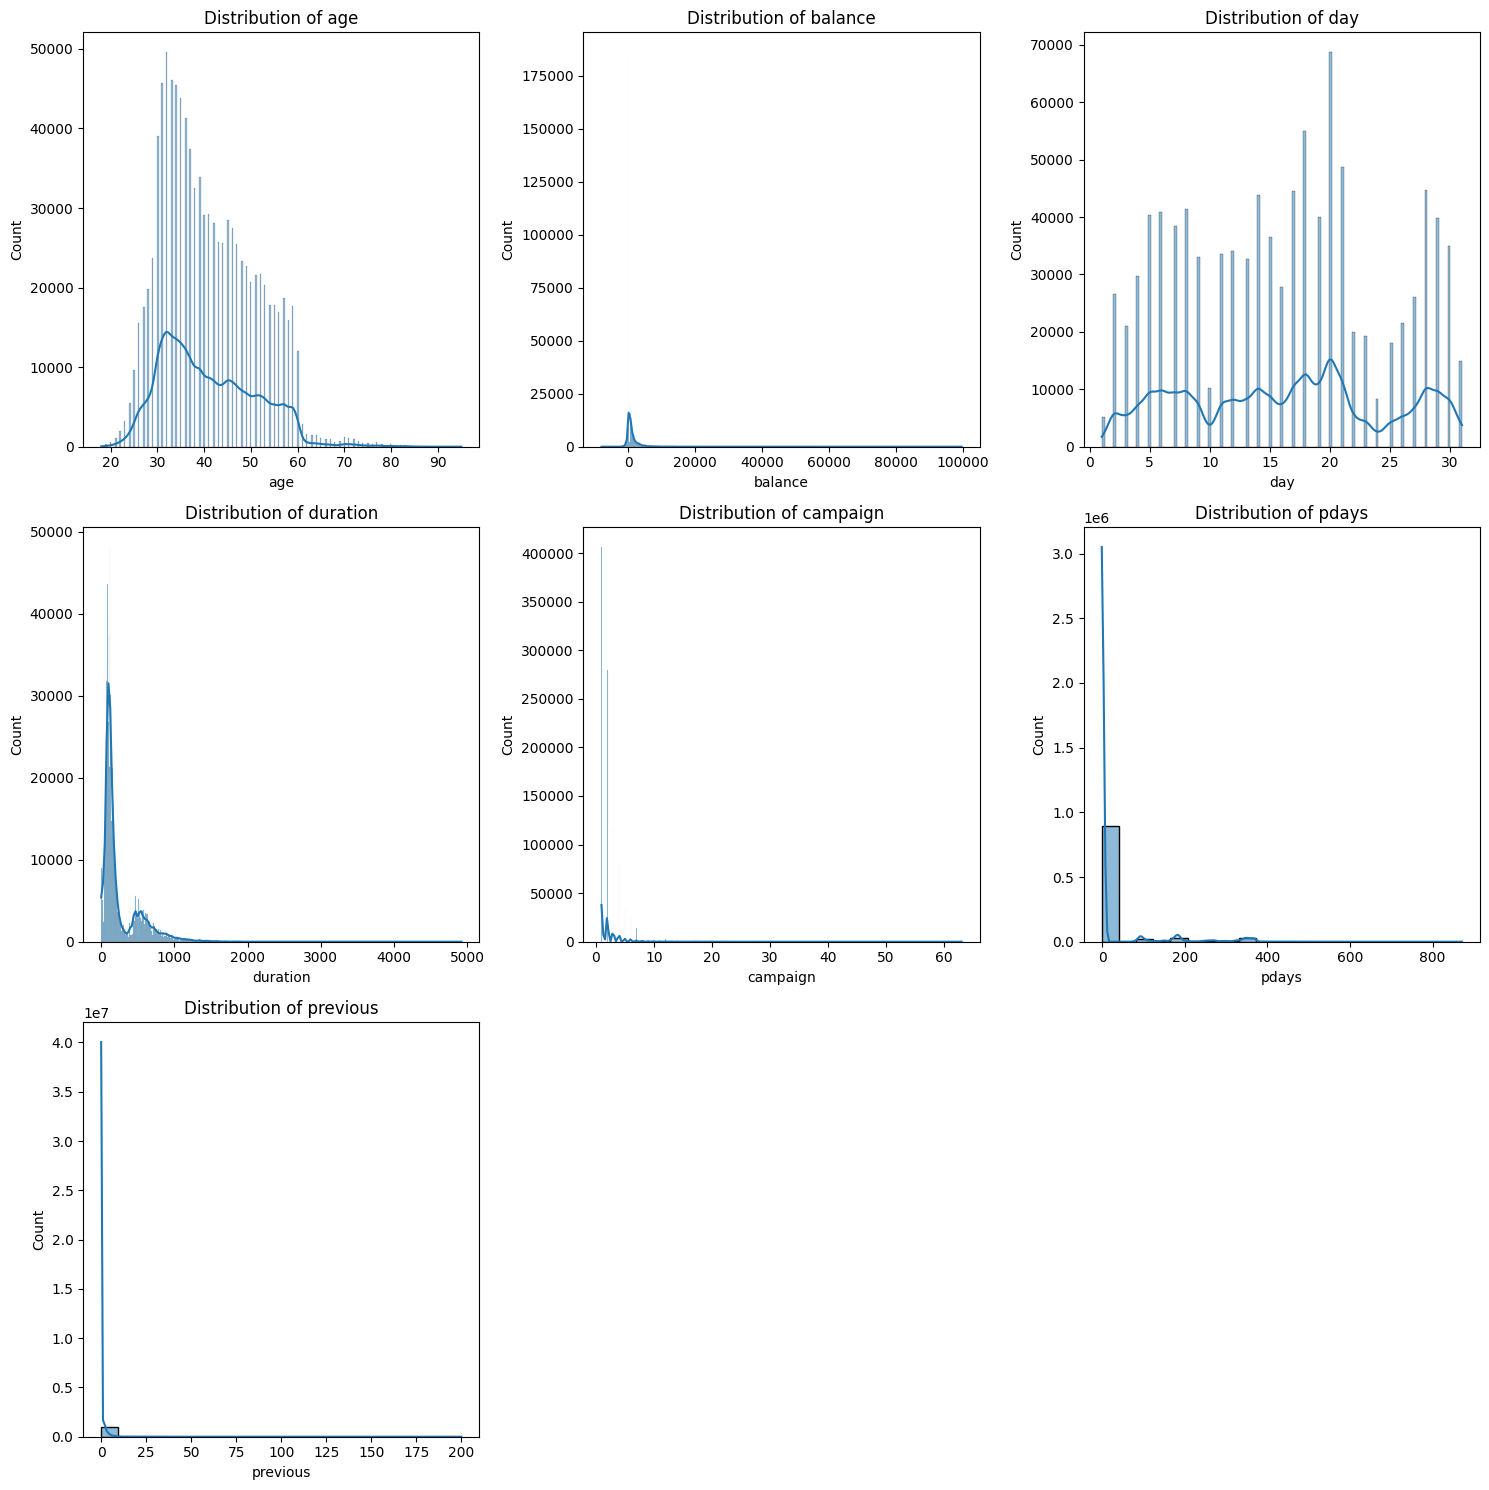

In [119]:
histplot_all_dataframe(all_data_numerical)

In [121]:
all_data_numerical.describe()

,age,balance,day,duration,campaign,pdays,previous
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,40.927879,1202.407136,16.116924,256.007423,2.576143,22.379557,0.299841
std,10.094523,2812.750998,8.252748,272.268420,2.716302,77.219149,1.348254
min,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000
50%,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000
75%,48.000000,1390.000000,21.000000,359.000000,3.000000,-1.000000,0.000000
max,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000


In [122]:
check_same_value_more_than_percentage(all_data_categorical, 0.8)

Column default; Repeated value: no; 982994 times of 1000000
Column loan; Repeated value: no; 859980 times of 1000000
Column poutcome; Repeated value: unknown; 896565 times of 1000000


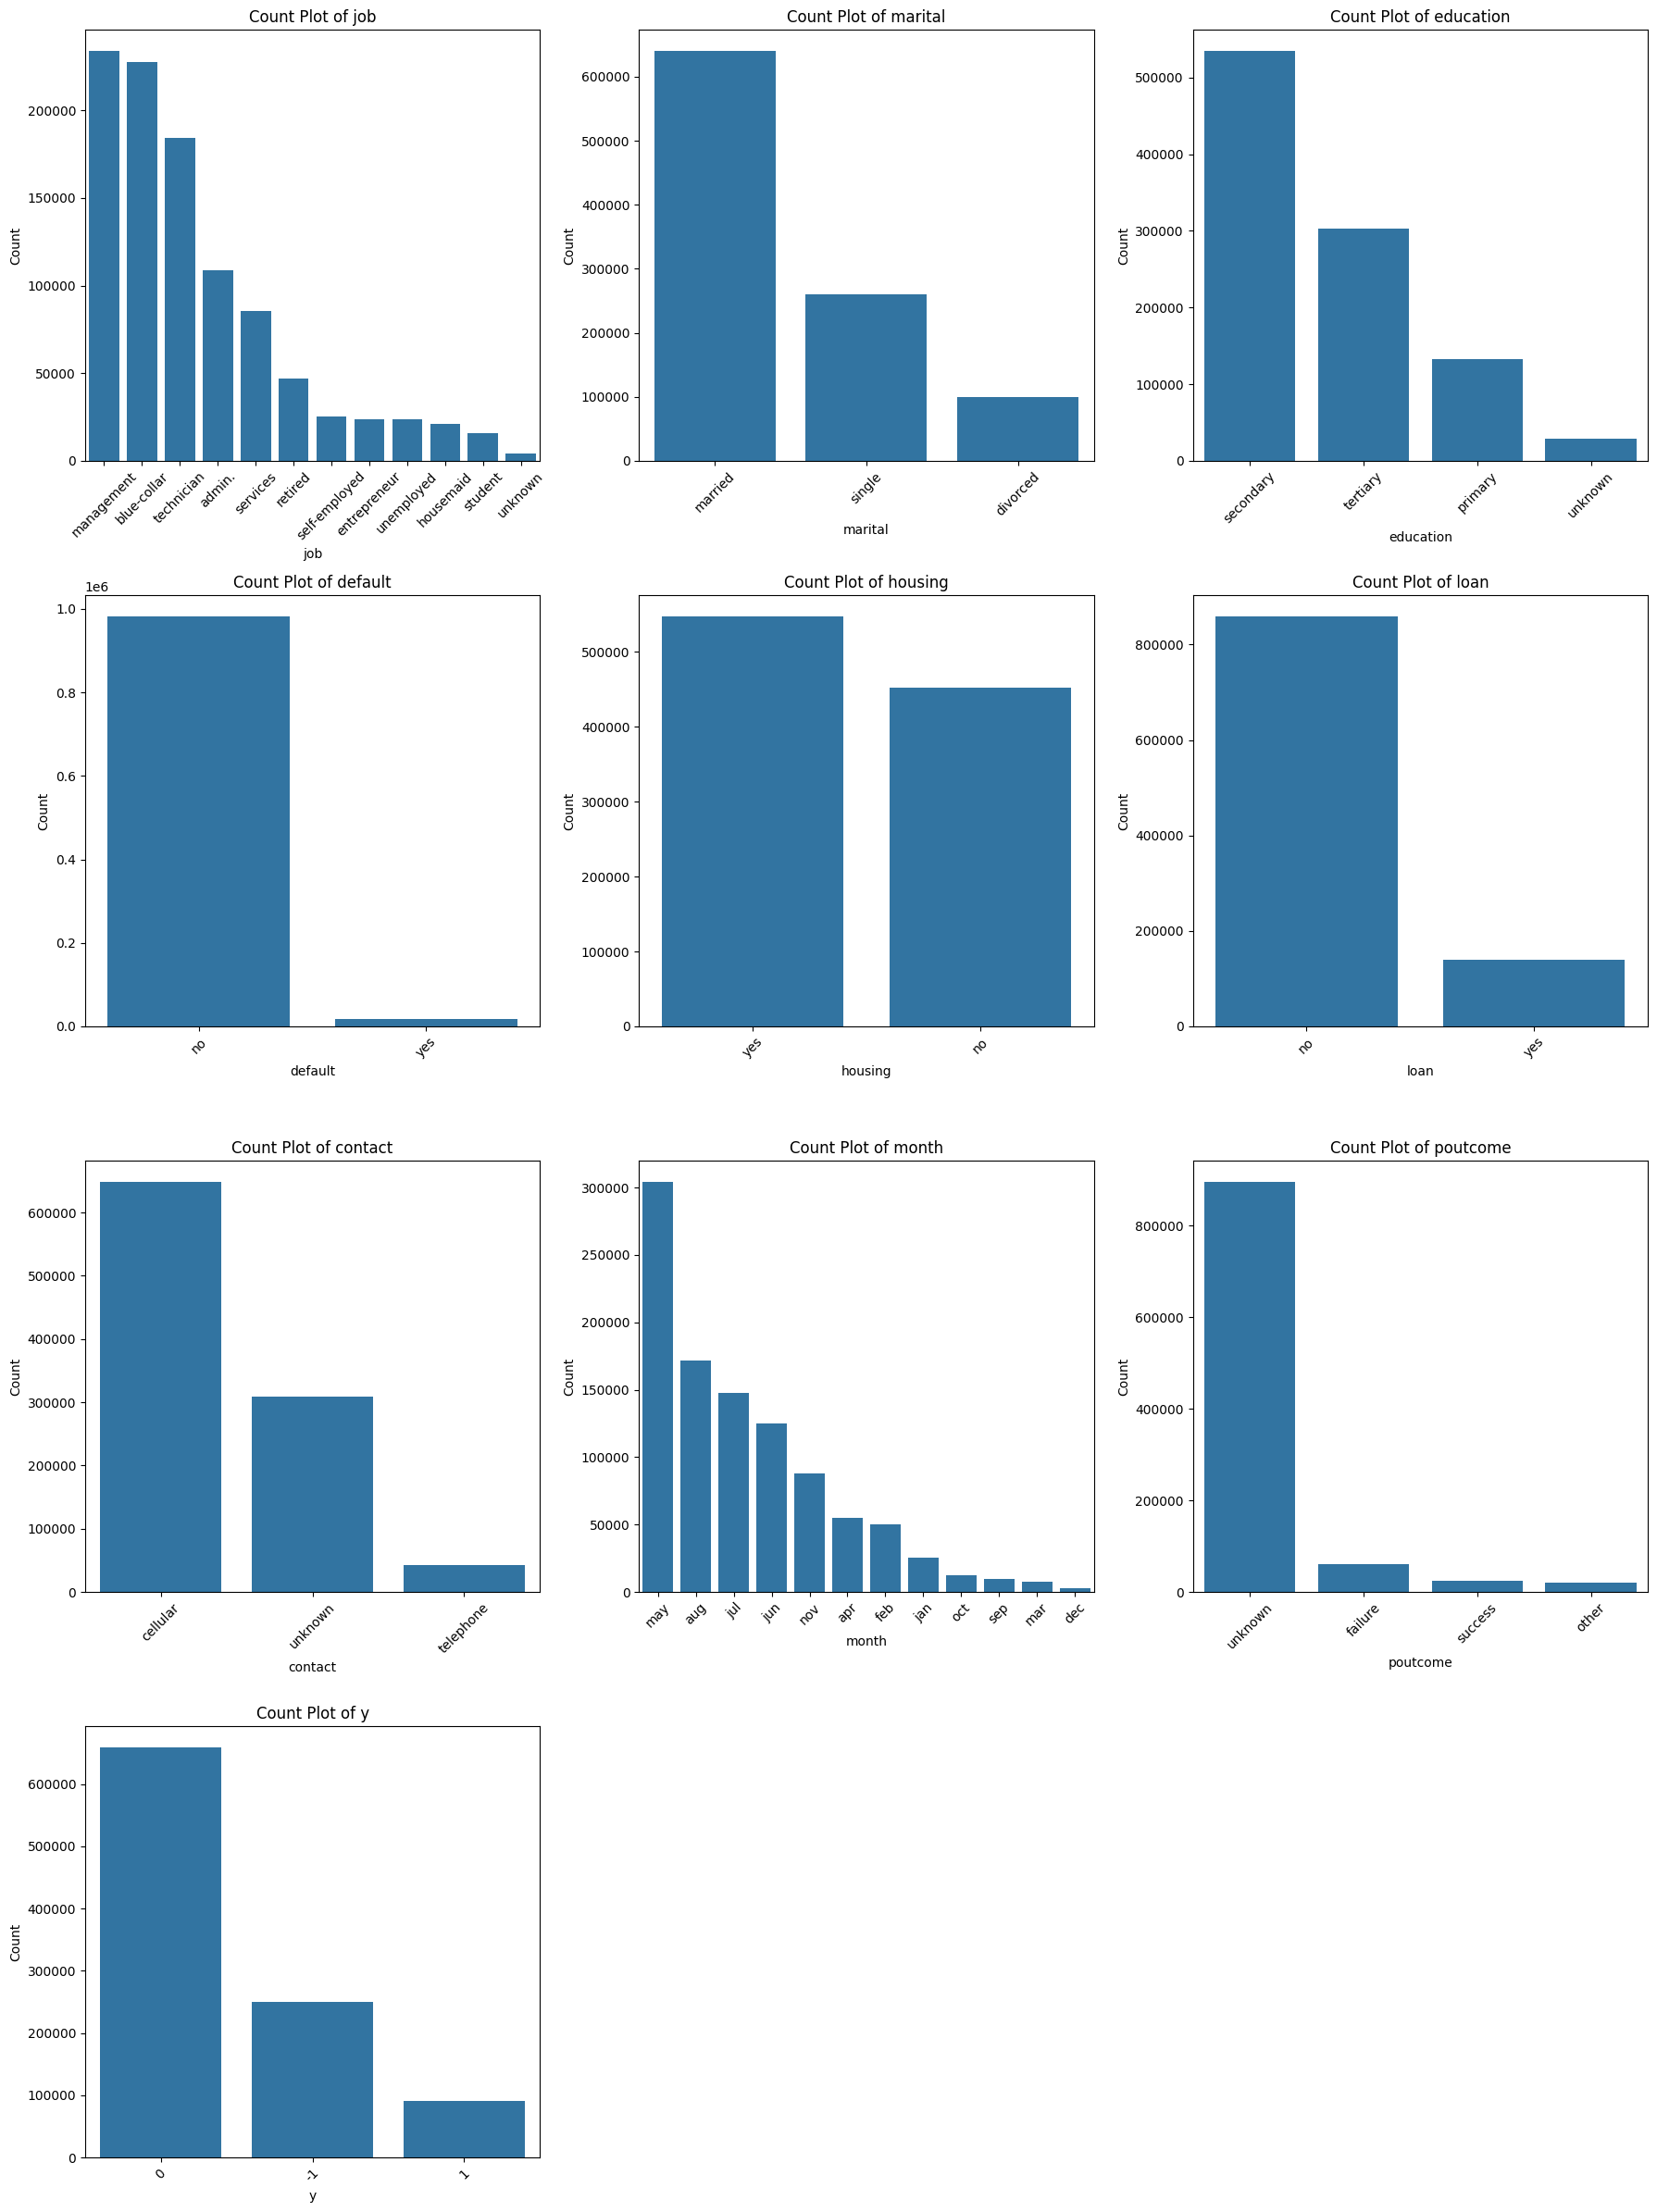

In [123]:
countplot_all_dataframe(all_data_categorical)

## Bivariate analysis

### Categorical vs Categorical

In [124]:
train_data_categorical_ba = all_data_categorical.loc[all_data_categorical['y'] > -1]

train_data_categorical_ba

,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,technician,married,secondary,no,no,no,cellular,aug,unknown,0
1,blue-collar,married,secondary,no,no,no,unknown,jun,unknown,0
2,blue-collar,married,secondary,no,yes,no,unknown,may,unknown,0
3,student,single,secondary,no,yes,no,unknown,may,unknown,0
4,technician,married,secondary,no,yes,no,cellular,feb,unknown,1
...,...,...,...,...,...,...,...,...,...,...
749995,services,single,secondary,no,no,yes,unknown,jul,unknown,1
749996,retired,divorced,tertiary,no,no,no,cellular,aug,unknown,0
749997,blue-collar,married,secondary,no,yes,no,cellular,apr,unknown,0
749998,technician,married,secondary,no,no,no,cellular,aug,unknown,0


In [125]:
count_data = train_data_categorical_ba.groupby(['y', 'default']).size().reset_index(name='count')

count_data

,y,default,count
0,0,no,647258
1,0,yes,12254
2,1,no,89893
3,1,yes,595


#### Using contingency table and chi square test of independence

I have to study this part more deeply before aplying it in my EDA.
For this competition I will pass but in the next one I will by studying this topic (statistical hypotesis testing)

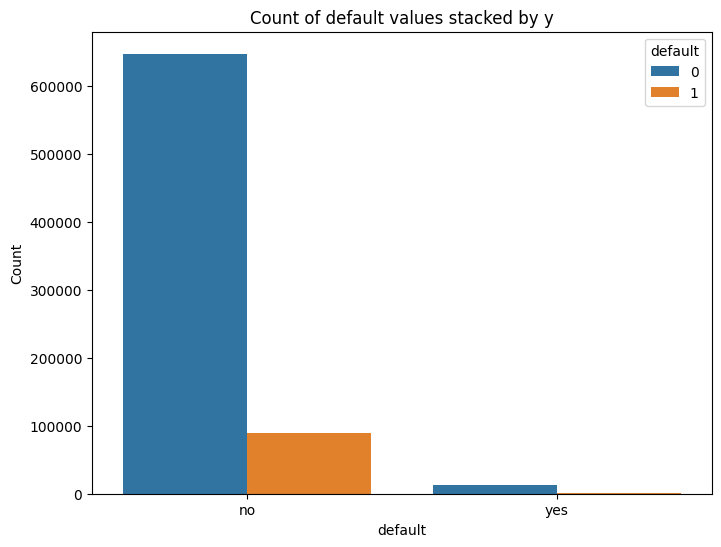

In [126]:
# Create a count DataFrame
count_data = train_data_categorical_ba.groupby(['y', 'default']).size().reset_index(name='count')

# Create the stacked bar plot
plt.figure(figsize=(8, 6))
sns.barplot(data=count_data, x='default', y='count', hue='y', estimator=sum, errorbar=None)

plt.xlabel('default')
plt.ylabel('Count')
plt.title('Count of default values stacked by y')
plt.legend(title='default')

plt.show()

In [127]:
# Create contingency table
contingency_table = pd.crosstab(train_data_categorical_ba['y'], train_data_categorical_ba['default'])

# Display the table
print(contingency_table)

# With totals
print(pd.crosstab(train_data_categorical_ba['y'], train_data_categorical_ba['default'], margins=True))

# Percentage of each cell out of the total (overall distribution)
print(pd.crosstab(train_data_categorical_ba['y'], train_data_categorical_ba['default'], normalize='all'))

# Percentage within each row (each row sums to 1)
pd.crosstab(train_data_categorical_ba['y'], train_data_categorical_ba['default'], normalize='index')

default      no    yes
y                     
0        647258  12254
1         89893    595
default      no    yes     All
y                             
0        647258  12254  659512
1         89893    595   90488
All      737151  12849  750000
default        no       yes
y                          
0        0.863011  0.016339
1        0.119857  0.000793


default,no,yes
y,,
0,0.981420,0.018580
1,0.993425,0.006575


In [128]:
contingency_table

default,no,yes
y,,
0,647258,12254
1,89893,595


In [129]:
chi2, p, dof, expected = chi2_contingency(contingency_table.to_numpy())  # Exclude "All" row and column
print(f"Chi2: {chi2}, p-value: {p}, Degrees of Freedom: {dof}")


Chi2: 680.3226427423159, p-value: 5.685409277005814e-150, Degrees of Freedom: 1


#### Back to normal (not using chi for now)

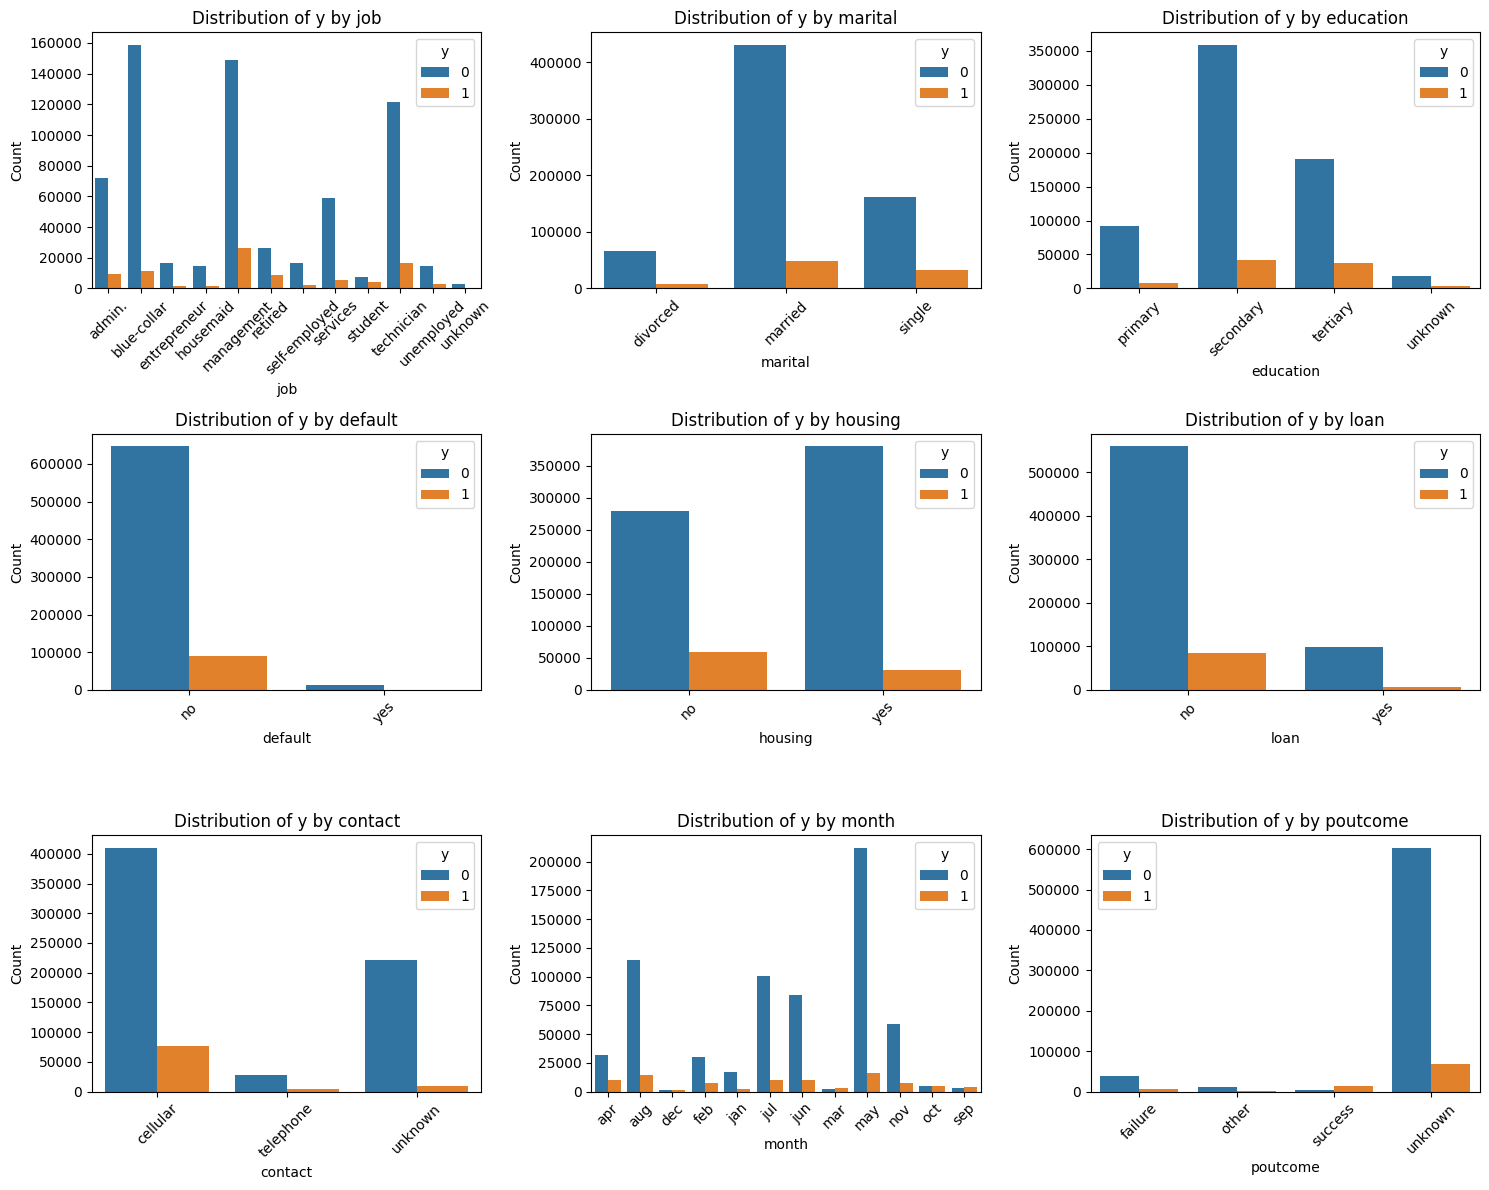

In [130]:
bivariate_stacked_plot(train_data_categorical_ba, 'y')

Using the eyeball test, it seems like all categorical variables could to some degree be related to the target variable.
In other words there isn't any variable that is clearly unrelated 

### Numerical vs Categorical

In [131]:
train_data_numerical_ba = all_data_numerical.copy(deep=True)
train_data_numerical_ba['y'] = all_data_categorical['y']
train_data_numerical_ba = train_data_numerical_ba.loc[train_data_numerical_ba['y'] > -1] # Only Train dataset
train_data_numerical_ba

,age,balance,day,duration,campaign,pdays,previous,y
0,42,7,25,117,3,-1,0,0
1,38,514,18,185,1,-1,0,0
2,36,602,14,111,2,-1,0,0
3,27,34,28,10,2,-1,0,0
4,26,889,3,902,1,-1,0,1
...,...,...,...,...,...,...,...,...
749995,29,1282,4,1006,2,-1,0,1
749996,69,631,19,87,1,-1,0,0
749997,50,217,17,113,1,-1,0,0
749998,32,-274,26,108,6,-1,0,0


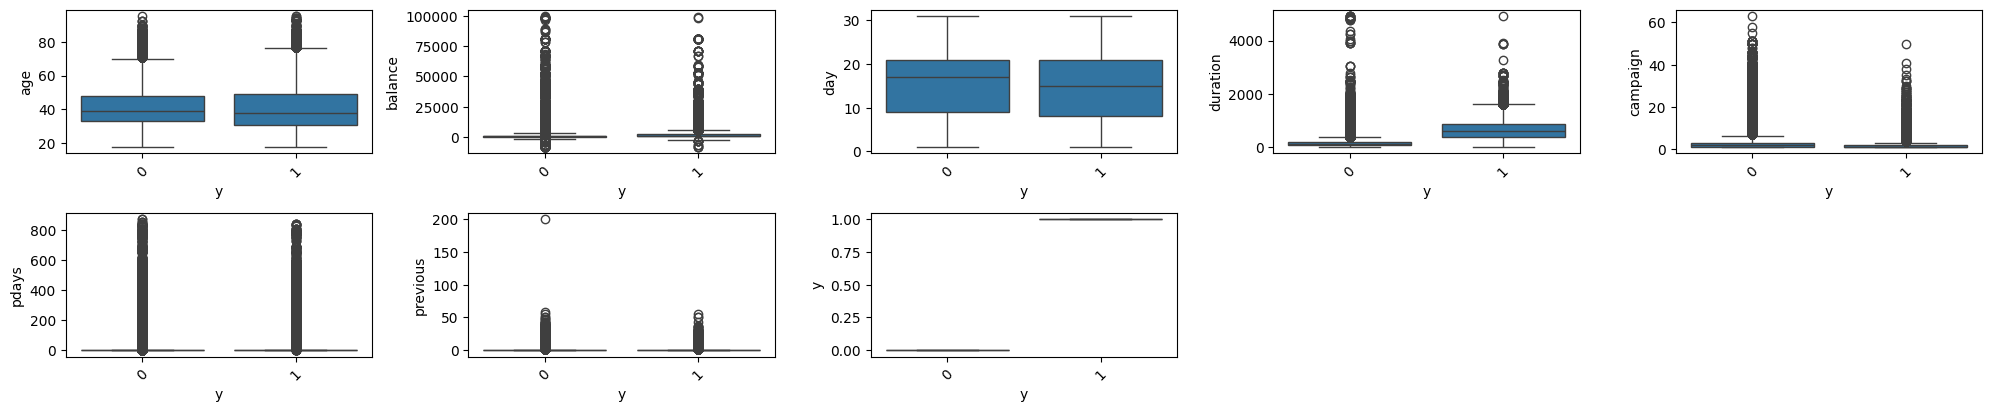

In [145]:
bivariate_boxplot_violinplot(train_data_numerical_ba, 'y', 'c')

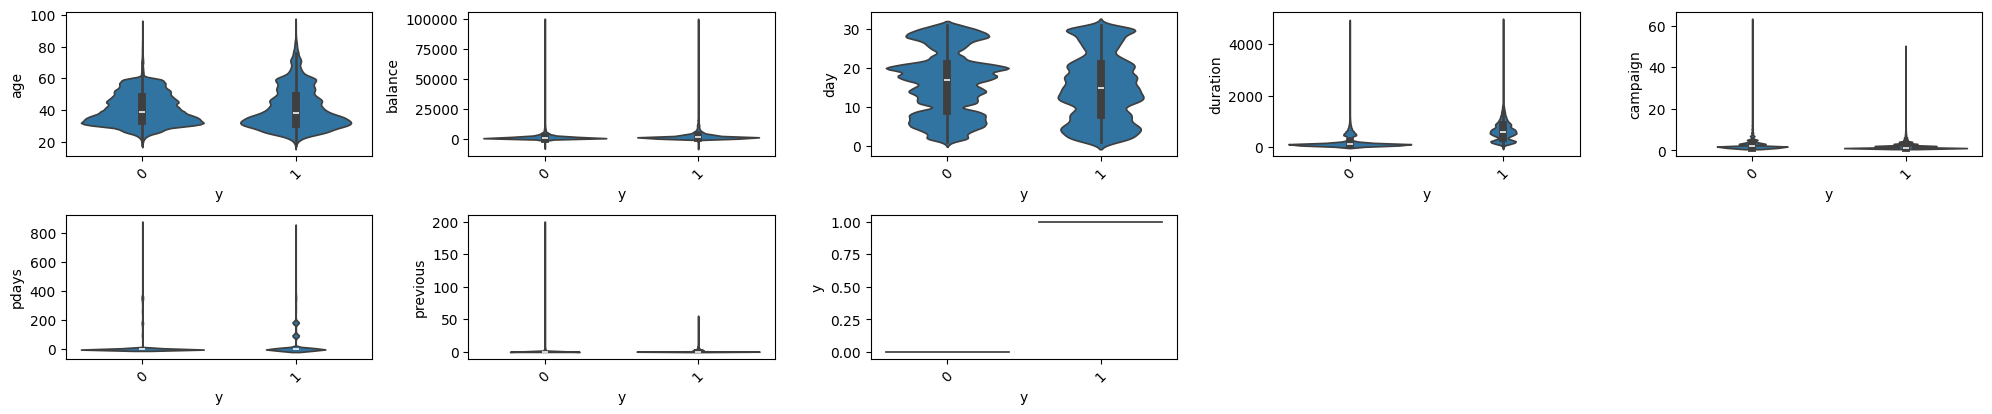

In [146]:
bivariate_boxplot_violinplot(train_data_numerical_ba, 'y', 'c', 'v')

At first glanze it seems like duration is the most related to y, and day and age the least. The rest of the variables are hard to read due to outliers. So lets do some feature engineering with the outliers only with the purpouse of visualization

#### FE outliers for visualization purpouses

In [169]:
train_data_numerical_ba.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


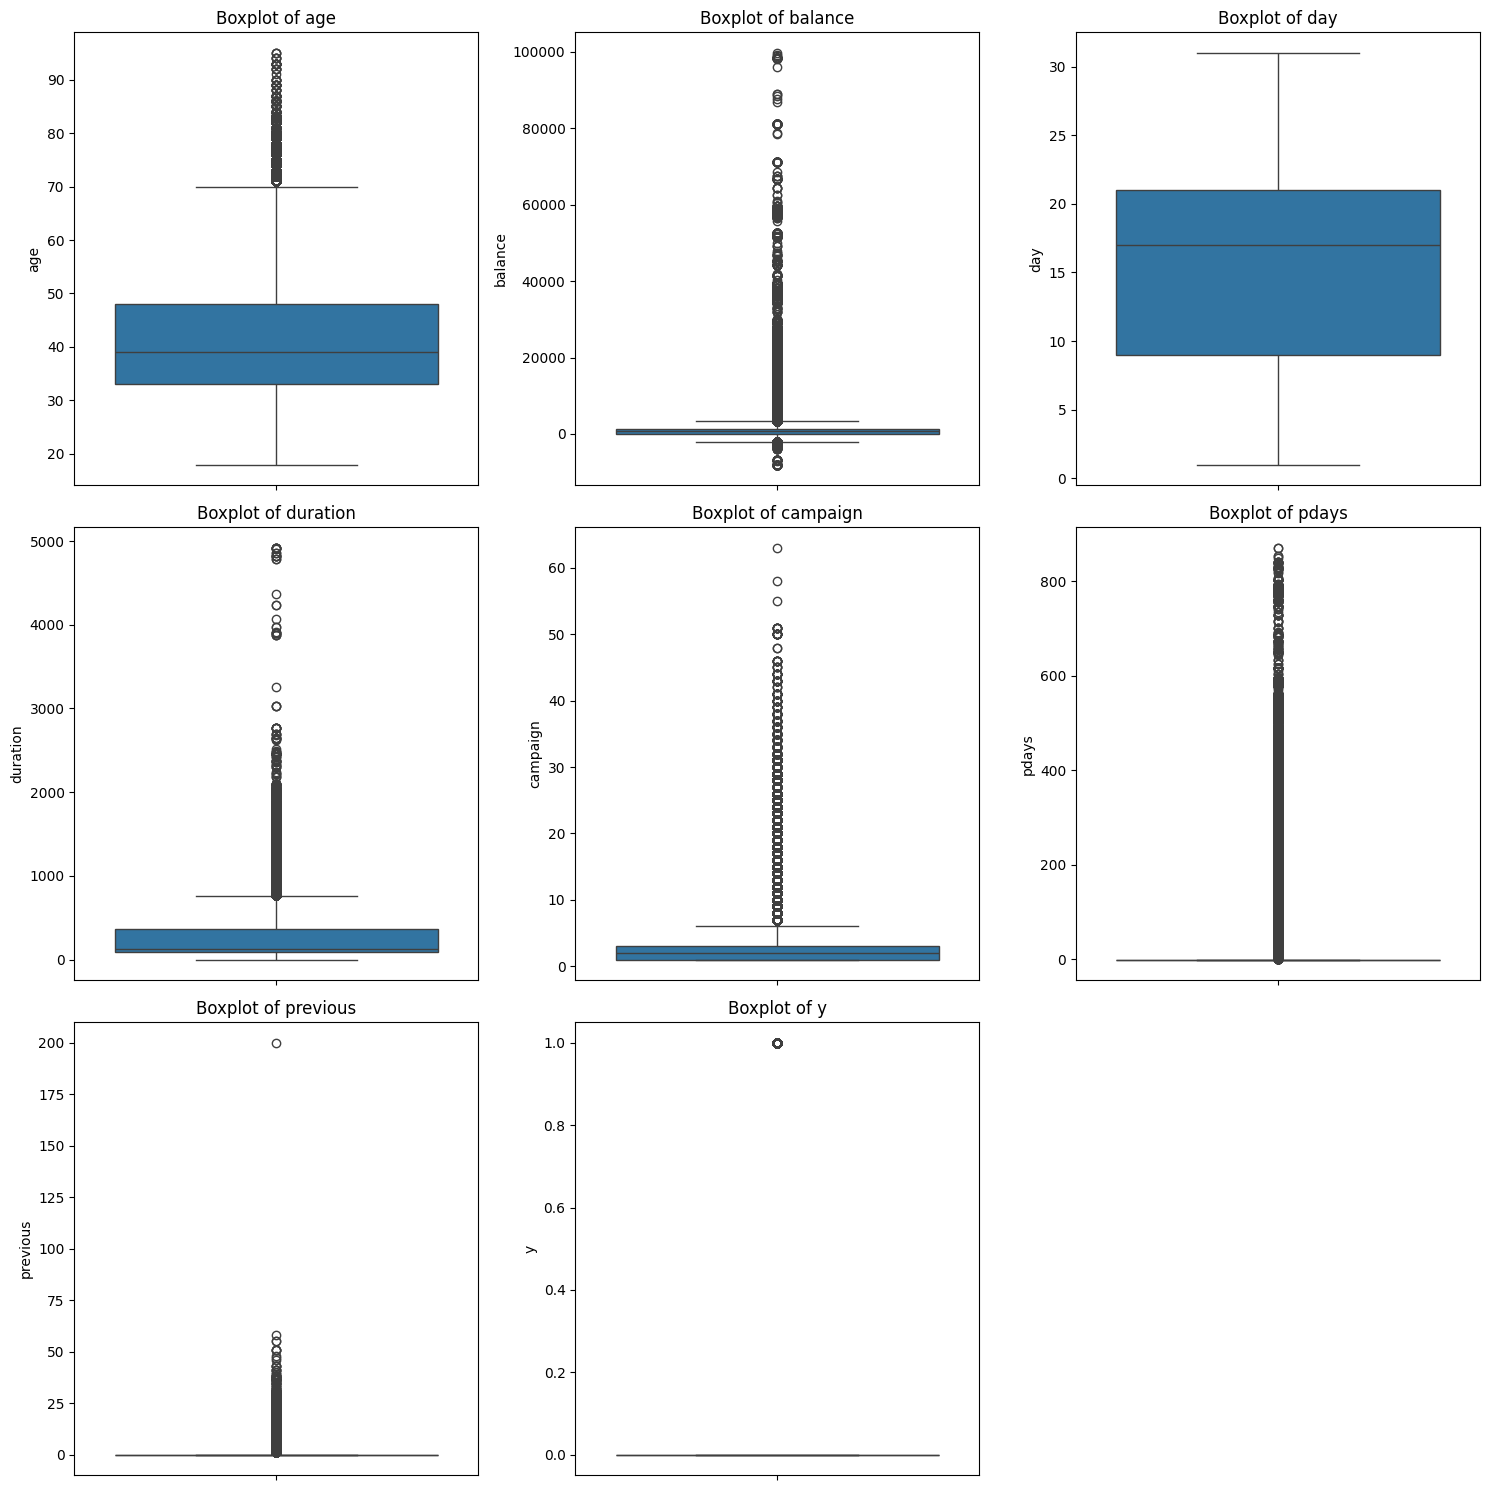

In [148]:
boxplot_all_dataframe(train_data_numerical_ba)

<Axes: xlabel='y', ylabel='previous'>

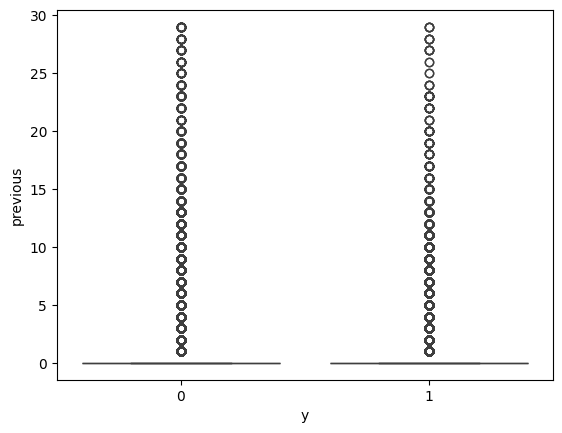

In [171]:
sns.boxplot(x='y', y='previous', data=train_data_numerical_ba.loc[train_data_numerical_ba['previous'] < 30])

<Axes: xlabel='y', ylabel='pdays'>

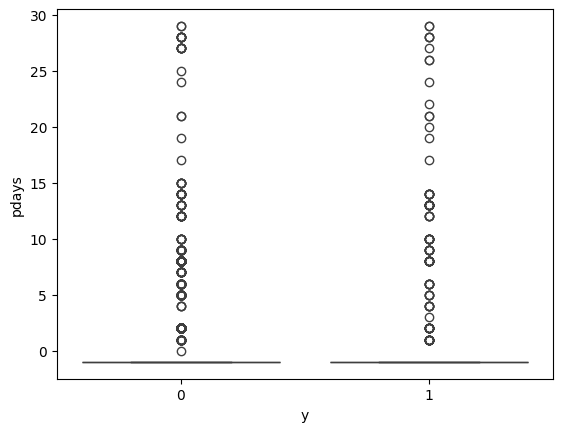

In [170]:
sns.boxplot(x='y', y='pdays', data=train_data_numerical_ba.loc[train_data_numerical_ba['pdays'] < 30])

<Axes: xlabel='y', ylabel='campaign'>

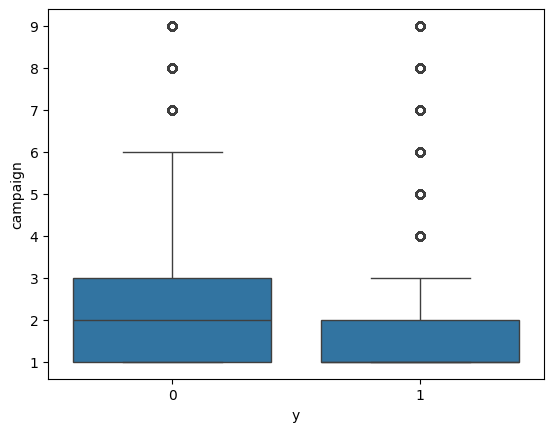

In [166]:
sns.boxplot(x='y', y='campaign', data=train_data_numerical_ba.loc[train_data_numerical_ba['campaign'] < 10])

<Axes: xlabel='y', ylabel='balance'>

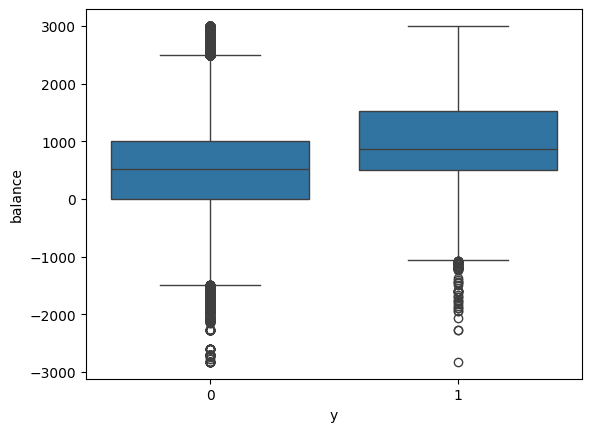

In [163]:
sns.boxplot(x='y', y='balance', data=train_data_numerical_ba.loc[(train_data_numerical_ba['balance'] < 3000) & (train_data_numerical_ba['balance'] > -3000)])

Conclusions:
pdays and previous can be deleted; Extremely skewed to the right, beyond salvation \
balance could be deleted; I woud need a statistical test to check, but in this competition I will not use them because I dont fully understand them yet. So for now I will simply check if the model its better withouth it. Maybe a transformation can be applied???

## Feature Engineering

Transformation:
Remove: 'day' and only use 'month';
Remove: 'pdays' and 'previous';
Could be Removed: 'default', 'loan', 'poutcome'; for each of those variables more than 80% of instances have the same value 
Could be Removed or applied a transformation: 'balance'

In [17]:
all_data_fe = all_data.copy(deep=True)

In [18]:
# Apply LabelEncoder to all object (categorical) columns
le = LabelEncoder()

all_data_fe = all_data_fe.apply(lambda col: le.fit_transform(col) if col.dtype == 'object' else col)

all_data_fe

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,9,1,1,0,7,0,0,0,25,1,117,3,-1,0,3,0
1,38,1,1,1,0,514,0,0,2,18,6,185,1,-1,0,3,0
2,36,1,1,1,0,602,1,0,2,14,8,111,2,-1,0,3,0
3,27,8,2,1,0,34,1,0,2,28,8,10,2,-1,0,3,0
4,26,9,1,1,0,889,1,0,0,3,3,902,1,-1,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,43,4,1,2,0,0,1,0,0,18,9,65,2,-1,0,3,-1
249996,40,7,1,3,0,522,1,0,0,19,9,531,1,189,1,0,-1
249997,63,5,1,0,0,33,0,0,0,3,5,178,1,92,8,2,-1
249998,50,1,1,0,0,2629,1,0,2,30,8,163,2,-1,0,3,-1


## Modeling

Strategy:\
1º) ML Models
  - First validate various models/ensemble techniques with Cross Validation 
  - Then do hyperparameter tuning with gridsearch or randomsearch on the best ones
  - Then do voting or stacking with them, that is the final prediction

2º) Deep Learning NN
  - Create a model
  - Hyperparameter tuning with CV 
  - Generate predictions

In [19]:
train_f = all_data_fe.loc[all_data_fe['y'] > -1].copy(deep=True)

test_f = all_data_fe.loc[all_data_fe['y'] == -1].copy(deep=True)
test_f.drop('y', axis=1, inplace=True)

### ML models

In [20]:
""" PARA UN SOLO MODELO:
# Step 1: Separate features (X) and target (y)
X = train_ml.drop('y', axis=1)  # All columns except 'y'
y = train_ml['y']               # Target variable

# Step 2: Define the model and parameter grid
ab = AdaBoostClassifier()
ab_params = {
    'n_estimators': [40, 50, 70],
    'learning_rate': [0.8, 1, 1.2],
    'random_state': [42]
}

# Step 3: Create GridSearchCV with a specified cv value (e.g., 5-fold)
gc = GridSearchCV(ab, ab_params, scoring='f1', cv=5, n_jobs=-1, verbose=1)

# Step 4: Fit the grid search to your training data
gc.fit(X, y)

# Optional: Get the best parameters and best score
print("Best parameters:", gc.best_params_)
print("Best cross-validation score:", gc.best_score_)
"""

' PARA UN SOLO MODELO:\n# Step 1: Separate features (X) and target (y)\nX = train_ml.drop(\'y\', axis=1)  # All columns except \'y\'\ny = train_ml[\'y\']               # Target variable\n\n# Step 2: Define the model and parameter grid\nab = AdaBoostClassifier()\nab_params = {\n    \'n_estimators\': [40, 50, 70],\n    \'learning_rate\': [0.8, 1, 1.2],\n    \'random_state\': [42]\n}\n\n# Step 3: Create GridSearchCV with a specified cv value (e.g., 5-fold)\ngc = GridSearchCV(ab, ab_params, scoring=\'f1\', cv=5, n_jobs=-1, verbose=1)\n\n# Step 4: Fit the grid search to your training data\ngc.fit(X, y)\n\n# Optional: Get the best parameters and best score\nprint("Best parameters:", gc.best_params_)\nprint("Best cross-validation score:", gc.best_score_)\n'

In [21]:
# --- 1. Define models and their hyperparameter grids ---
MLA = [
    ('AdaBoost', AdaBoostClassifier(), {
        'n_estimators': [50, 75, 100],
        'learning_rate': [0.5, 1.0, 1.5]
    }),

    ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.2],
        'max_depth': [3, 6]
    })
]

# --- 2. Load and prepare your data ---
# Assume train_ml is your DataFrame
X = train_f.drop('y', axis=1)
y = train_f['y']

# Optional: If using SVM or linear models, scale features
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# We'll wrap linear models in a pipeline with scaling
PIPELINES = ['LogisticRegression', 'SGD', 'SVM']

# --- 3. Results collection ---
results = []

for name, model, params in MLA:
    print(f"\n--- Tuning {name} ---")
    
    # Use pipeline with scaling for linear models
    if name in PIPELINES:
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', model)
        ])
        # Adjust param keys for pipeline
        params = {f'clf__{k}': v for k, v in params.items()}
    
    # Grid search with cross-validation
    gs = GridSearchCV(
        model,
        params,
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,
        verbose=0
    )
    
    # Fit grid search
    gs.fit(X, y)
    
    # Best model from grid search
    best_model = gs.best_estimator_
    
    # Cross-validate best model (same as GridSearchCV inner CV, but for consistency)
    cv_scores = cross_val_score(best_model, X, y, scoring='roc_auc', cv=5)
    
    # Collect results
    results.append({
        'Model': name,
        'Best_Params': gs.best_params_,
        'CV_Mean_AUC': cv_scores.mean(),
        'CV_Std_AUC': cv_scores.std(),
        'Best_AUC_Score': gs.best_score_  # mean score from inner CV
    })
    
    print(f"Best AUC: {gs.best_score_:.4f} (+/- {cv_scores.std() * 2:.4f})")

# --- 4. Create results DataFrame ---
results_df = pd.DataFrame(results)

# Sort by performance
results_df.sort_values(by='CV_Mean_AUC', ascending=False, inplace=True)

# Optional: round values
results_df['CV_Mean_AUC'] = results_df['CV_Mean_AUC'].round(4)
results_df['CV_Std_AUC'] = results_df['CV_Std_AUC'].round(4)

# Display
print("\n" + "="*60)
print("Model Comparison After Hyperparameter Tuning")
print("="*60)
print(results_df[['Model', 'CV_Mean_AUC', 'CV_Std_AUC', 'Best_Params']])



--- Tuning AdaBoost ---
Best AUC: 0.9496 (+/- 0.0018)

--- Tuning XGB ---


/home/jose/kaggle/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:53:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jose/kaggle/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:53:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jose/kaggle/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:53:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jose/kaggle/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:53:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jose/kaggle/lib/python3.12/site-packages/xgboost/training.py:183: 

Best AUC: 0.9656 (+/- 0.0009)

Model Comparison After Hyperparameter Tuning
      Model  ...                                        Best_Params
1       XGB  ...  {'learning_rate': 0.2, 'max_depth': 6, 'n_esti...
0  AdaBoost  ...        {'learning_rate': 1.5, 'n_estimators': 100}

[2 rows x 4 columns]


In [22]:
results_df[['Model', 'CV_Mean_AUC', 'CV_Std_AUC', 'Best_Params']]

,Model,CV_Mean_AUC,CV_Std_AUC,Best_Params
1,XGB,0.9656,0.0005,"{'learning_rate': 0.2, 'max_depth': 6, 'n_esti..."
0,AdaBoost,0.9496,0.0009,"{'learning_rate': 1.5, 'n_estimators': 100}"


In [32]:
# 1. Extract best parameters (you already did this)
best_params = results_df.loc[results_df['Model'] == 'XGB', 'Best_Params'].iloc[0]
print("Best Parameters:", best_params)

# 2. Create the best XGBoost model using those parameters
best_xgb_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')

# 3. Fit the model on your full training data
best_xgb_model.fit(X, y)  # X_train, y_train are your training features and labels

# 4. Make predictions
y_pred = best_xgb_model.predict(test_f)                    # Predicted classes
y_pred_proba = best_xgb_model.predict_proba(test_f)[:, 1]  # Predicted probabilities (for AUC/ROC)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100}


/home/jose/kaggle/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:13:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
best_params_ada = results_df.loc[results_df['Model'] == 'AdaBoost', 'Best_Params'].iloc[0]
best_ada_model = AdaBoostClassifier(**best_params_ada)

best_ada_model.fit(X, y)

y_pred = best_ada_model.predict(test_f)


In [56]:
# Get probabilities for class 1
y_pred_proba_xgb = best_xgb_model.predict_proba(test_f)[:, 1]

y_pred_proba_xgb = [round(float(i), 1) for i in y_pred_proba_xgb]

y_pred_proba_xgb

[0.0,
 0.1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3,
 0.3,
 0.0,
 0.4,
 0.0,
 0.0,
 0.4,
 0.0,
 0.1,
 0.1,
 0.0,
 0.0,
 0.2,
 0.1,
 0.1,
 0.2,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,
 0.0,
 0.3,
 1.0,
 0.3,
 0.0,
 0.0,
 0.0,
 0.7,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.1,
 0.0,
 0.0,
 0.0,
 0.1,
 0.0,
 0.0,
 0.0,
 0.7,
 0.1,
 0.0,
 0.0,
 0.7,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2,
 0.0,
 0.0,
 0.1,
 0.0,
 0.0,
 0.0,
 0.9,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3,
 0.1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4,
 0.2,
 0.1,
 0.0,
 0.1,
 0.0,
 0.0,
 0.1,
 0.9,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8,
 0.0,
 0.0,
 0.1,
 0.0,
 0.0,
 0.4,
 0.0,
 0.0,
 0.1,
 0.0,
 0.7,
 0.2,
 0.0,
 0.2,
 0.0,
 0.0,
 0.0,
 0.0,
 0.1,
 0.0,
 0.4,
 0.1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.7,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2,
 0.0,
 0.1,
 0.0,
 0.1,
 0.0,
 0.0,
 0.1,
 0.0,
 1.0,
 0.0,
 0.1,
 0.4,
 0.8,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.1,
 0.2,
 0.0,
 0.1

Okay so first iteration with xgb, without doing ANY feature engineering and I already got 0.95865 accuracy in Kaggle. Position 1636 in the leaderboard, less than half but still... I didnt do any FE

In [ ]:

output_xgb = pd.DataFrame({'id': test['id'], 'y': y_pred_proba_xgb})

output_xgb.to_csv('output_xgb.csv', index=False)

### Deep Learning

In [142]:
X = train_f.drop('y', axis=1).to_numpy() # Features

X = StandardScaler().fit_transform(X)

y = train_f['y'].to_numpy() # Target

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=32, shuffle=False)

In [161]:
class BcNN(nn.Module):
    def __init__(self, input_size, hidden_layers=[132, 64, 32], dropout_rate=0.2):
        super(BcNN, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Hidden layers
        for hidden_size in hidden_layers:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size

        # Output layer: single logit (no sigmoid!)
        layers.append(nn.Linear(prev_size, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        # Output shape: (batch_size, 1) → squeeze to (batch_size,)
        return self.network(x).squeeze(-1)


In [ ]:
num_positive = (y_train == 1).sum().item()  # number of positive (1) samples
num_negative = (y_train == 0).sum().item()  # number of negative (0) samples

# Avoid division by zero
assert num_positive > 0 and num_negative > 0, "One class has zero samples"

pos_weight = torch.tensor([num_negative / num_positive], dtype=torch.float32)
print(f"Class imbalance: {num_negative}:{num_positive} → pos_weight = {pos_weight.item():.3f}")

72283
527717
Class imbalance: 527717:72283 → pos_weight = 7.301


In [164]:
input_size = X_train.shape[1]  # number of features
model = BcNN(input_size=input_size, hidden_layers=[132, 64, 32], dropout_rate=0.2)
# Use BCEWithLogitsLoss with pos_weight for class imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# Adam optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [165]:
model.train()
epochs = 100

for epoch in range(epochs):
    optimizer.zero_grad()                    # Zero gradients
    outputs = model(X_train)                 # Forward pass
    loss = criterion(outputs, y_train)       # Compute loss
    loss.backward()                          # Backward pass
    optimizer.step()                         # Update weights

    if (epoch+1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray